# Load data for both GaAs samples (484 um and 420 um)
* perform FFT
* run the NR routine

In [2]:
from utils import move_to_thz_tds_directory
move_to_thz_tds_directory()

from Extraction.Extractor import Extractor 
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib widget 

ref_tab1 = pd.read_csv("Data_sets/complex_data/ref2.pulse.csv").to_numpy()
sample_tab1 = pd.read_csv("Data_sets/complex_data/GaAs-1-484.pulse.csv").to_numpy()

ref_tab2 = pd.read_csv("Data_sets/complex_data/ref2.pulse.csv").to_numpy()
sample_tab2 = pd.read_csv("Data_sets/complex_data/GaAs-2-420.pulse.csv").to_numpy()


extractor1 = Extractor(ref_tab1, sample_tab1, thickness=484*1e-6)
extractor2 = Extractor(ref_tab2, sample_tab2, thickness=420*1e-6)

for extractor in [extractor1, extractor2]:
    extractor.window(150, 150)
    extractor.fft_signals()
    extractor.calculate_refractive_index(n_0=3.6-0.2j)


Success! Current directory is now: /Users/pw/git_projects/thz-tds_repo/THz-TDS
phase offset fit frequency range:  [1.00072064 4.00288256]
slopes for reference  and sample:  -52.99936748367636 -77.4101640878909
mean squared error for ref and sample:  0.0536911333218702 0.05040809794351722
(should be ~< 1)
phase of H slope:  -24.41079660421456
mse of H slope:  0.000172827130732373


/Users/pw/git_projects/thz-tds_repo/THz-TDS/Extraction/Extractor.py:137: RuntimeWarning: divide by zero encountered in divide
  self.fast_n = 1 - (self.ph_transfer * c) / (2*np.pi*self.f_interp*1e12 * self.Length)
/Users/pw/git_projects/thz-tds_repo/THz-TDS/Extraction/transfer_functions.py:23: RuntimeWarning: overflow encountered in exp
  return (4 * n) / ((n + 1) ** 2) * np.exp(-1j * (n - 1) * w * length/ c)
/Users/pw/git_projects/thz-tds_repo/THz-TDS/Extraction/transfer_functions.py:23: RuntimeWarning: invalid value encountered in multiply
  return (4 * n) / ((n + 1) ** 2) * np.exp(-1j * (n - 1) * w * length/ c)


phase offset fit frequency range:  [1.00072064 4.00288256]
slopes for reference  and sample:  -52.99936748367636 -76.64513387103457
mean squared error for ref and sample:  0.0536911333218702 0.24614669358069735
(should be ~< 1)
phase of H slope:  -23.645766387358204
mse of H slope:  0.08945517067683861


# Compare real n of both samples

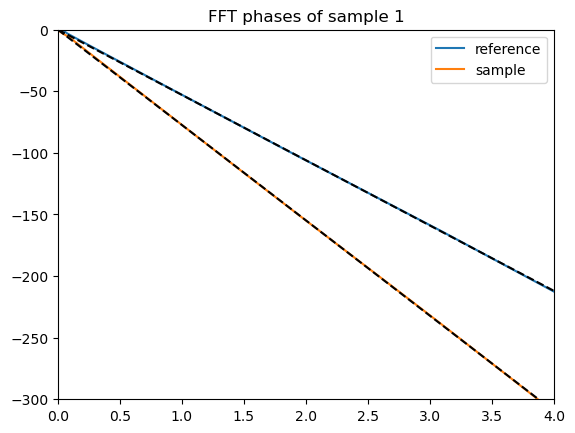

-52.99936748367636
-77.4101640878909
0.0536911333218702
0.05040809794351722


In [3]:
import numpy as np

df = extractor1.get_fft_data()[['interpolated frequency', 'phase_signal_ref', 'phase_signal_sample']]
f = df['interpolated frequency']
pr = df['phase_signal_ref']
ps = df['phase_signal_sample']

finds = np.arange(205,820)
coef_r = np.polyfit(f[finds], pr[finds], 1)
coef_s = np.polyfit(f[finds], ps[finds], 1)

a1 = -52.99936748367636 
a2 = -77.4101640878909 

plt.clf()
plt.xlim([0, 4]) 
plt.ylim([-300, 0])
plt.plot(f, pr, label='reference')
plt.plot(f, ps, label='sample')
plt.plot(f, f*a1, 'k--')
plt.plot(f, f*a2, 'k--')
plt.legend()
plt.title('FFT phases of sample 1')
plt.show()

print(a1)
print(a2)
print(np.mean(np.square(pr-f*a1)[finds]))
print(np.mean(np.square(ps-f*a2)[finds]))

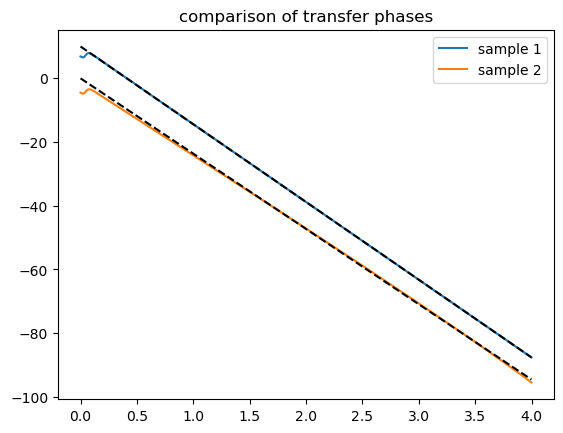

In [4]:
df1 = extractor1.get_fft_data()
df2 = extractor2.get_fft_data()

# join the dataframe to get all available data for the sample
df1 = df1.join(extractor1.get_refractive_index_data())
df2 = df2.join(extractor2.get_refractive_index_data())

# filter to get rid of useless datapoints
df1 = df1[df1['interpolated frequency'] <= 4.0]
df2 = df2[df2['interpolated frequency'] <= 4.0]

f1 = df1['interpolated frequency']
f2 = df2['interpolated frequency']

a1 = -24.41079660421456
a2 = -23.645766387358204
plt.plot(f1, df1['phase_transfer']+10, label="sample 1")  # artificial intercept because the slopes are close
plt.plot(f2, df2['phase_transfer'], label="sample 2")
plt.plot(f1, a1*f1+10, 'k--')
plt.plot(f2, a2*f2, 'k--')
plt.legend()
plt.title("comparison of transfer phases")
plt.show()

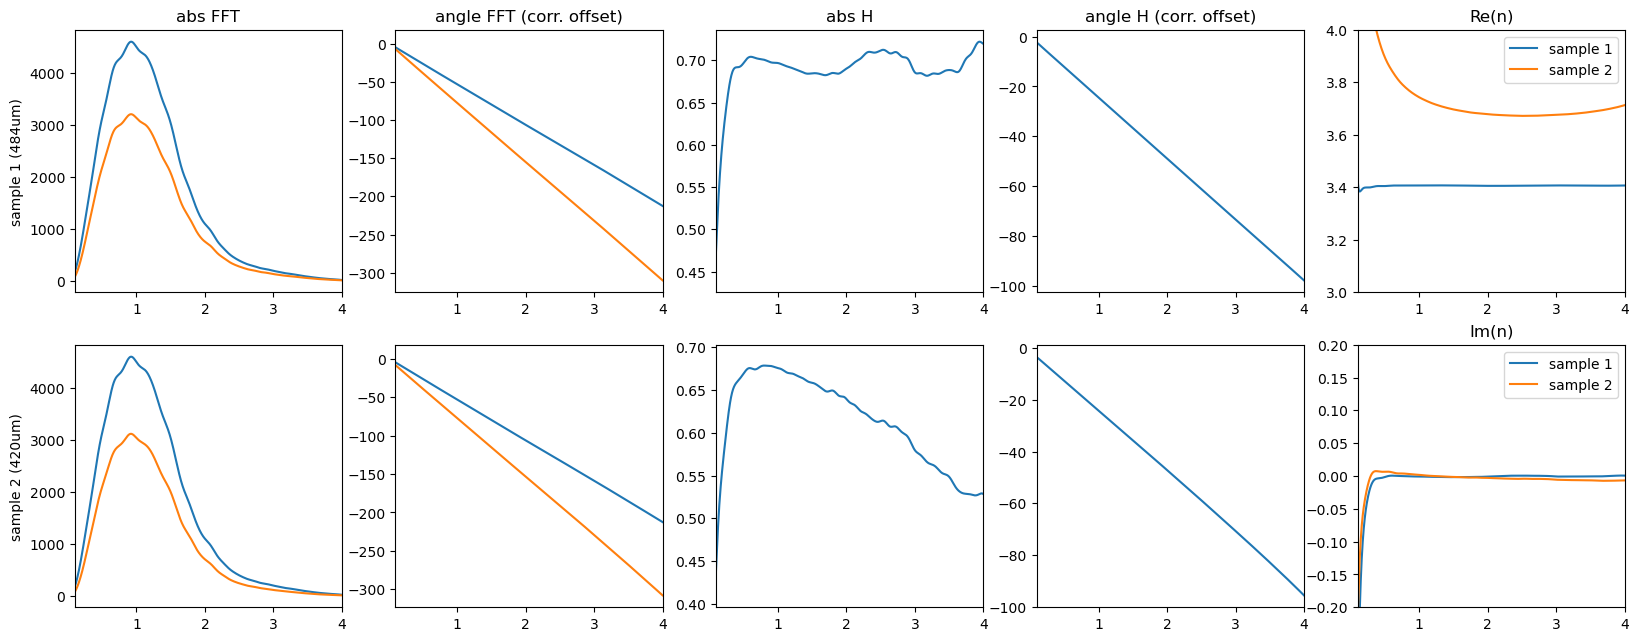

In [5]:
# plot a 2 row, 5 column overview
fig, ax = plt.subplots(2, 5, figsize=(20, 7.5))

# columns from the datafame that we're going to be using
columns = [['amplitude_signal_ref', 'amplitude_signal_sample'],
           ['phase_signal_ref', 'phase_signal_sample'],
           ['amplitude_transfer'],
           ['phase_transfer']]

# titles for the plots and limits
titles = ['abs FFT', 'angle FFT (corr. offset)', 'abs H', 'angle H (corr. offset)']
xlims = [0.1, 4]  # for all plots
ylims = [[3, 4], [-.2, .2]]  # only for n and k plots

# pop the dataframes in a list for convenience
dfs = [df1, df2]
fs = [f1, f2]

# we're using ylabels to show which rows correspond to which sample
ax[0,0].set_ylabel("sample 1 (484um)")
ax[1,0].set_ylabel("sample 2 (420um)")

# plot the first four columns using the same template
for i in range(4):
    ax[0,i].set_title(titles[i])

    for j in range(2):
        ax[j,i].set_xlim(xlims)
        ax[j,i].plot(fs[j], dfs[j][columns[i][0]])

        if len(columns[i]) > 1:
            ax[j,i].plot(fs[j], dfs[j][columns[i][1]])

# the last column is treated differently

columns_n = ['real_part', 'imaginary_part']
titles_n = ['Re(n)', 'Im(n)']
for i in range(2):
    ax[i,4].set_title(titles_n[i])
    ax[i,4].plot(f1, df1[columns_n[i]], label="sample 1")
    ax[i,4].plot(f2, df2[columns_n[i]], label="sample 2")
    ax[i,4].set_xlim(xlims)
    ax[i,4].set_ylim(ylims[i])
    ax[i,4].legend()

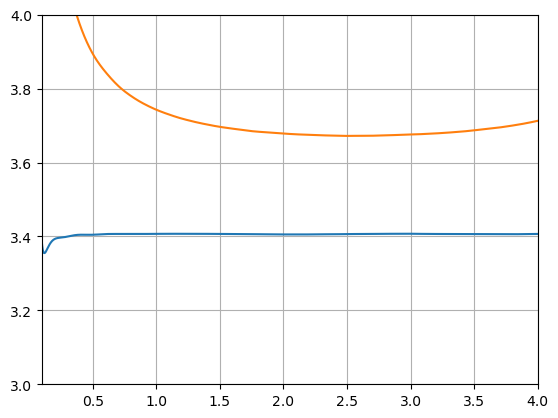

In [15]:
plt.plot(extractor1.f_interp, extractor1.fast_n)
plt.plot(extractor2.f_interp, extractor2.fast_n)
plt.xlim([0.1, 4])
plt.ylim([3, 4])
plt.grid()